In [1]:
# packages
import os
import gc
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, f1_score, mean_squared_error, accuracy_score, mean_squared_error,log_loss
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [2]:
EPOCHS = 500
LR = 1e-3
BS = 32
SEED = 42
MODEL_NAME ='model'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

In [3]:
df = pd.read_csv('./raw_data.csv')
df

,EQUIP_ID,MFG_DT,SALE_CD,MOLD_POS,REAL_POWER,CP,AX,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5
0,EQUIP1,2021-03-23,SALES 0,8,0.00,NaN,NaN,CORE1 A 02. 0570,CORE1 A 01. P3+3,CORE1 A 05. M0075,CORE1 A 8A. D-00,-6.4889,6.5811,0.00,0.12,0.12,0.12,0.25,0.25
1,EQUIP2,2021-03-23,SALES 1,1,-6.50,NaN,NaN,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,-6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50
2,EQUIP1,2021-03-25,SALES 2,2,0.00,NaN,NaN,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0000,CORE2 C 04. A-00,-7.3246,7.3802,0.00,0.12,0.12,0.25,0.25,0.25
3,EQUIP2,2021-03-25,SALES 3,6,-7.50,NaN,NaN,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,-6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62
4,EQUIP3,2021-04-09,SALES 4,1,-0.75,NaN,NaN,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,-7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175097,EQUIP13,2020-10-13,SALES 114,4,-5.25,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0850,CORE5 F 02. C-08,-6.3304,7.1881,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25
175098,EQUIP13,2020-10-14,SALES 114,5,-5.25,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0875,CORE5 F 02. D-08,-6.4933,6.8071,-5.25,-5.12,-5.12,-5.25,-5.25,-5.25
175099,EQUIP13,2020-10-16,SALES 114,6,-5.50,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. OK+1,CORE5 F 02. M0950,CORE5 F 02. C-09,-6.3582,0.0000,-5.50,-5.37,-5.37,-5.50,-5.50,-5.50
175100,EQUIP35,2020-10-14,SALES 114,7,-8.00,NaN,NaN,CORE5 F 01. 0570,CORE5 F 01. P1+0,CORE5 F 02. M1350,CORE5 F 02. C-13,-6.3056,7.7866,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(df['MOLD_IN_TOP'].value_counts())
print(df['MOLD_IN_BOT'].value_counts())
print(df['MOLD_OUT_TOP'].value_counts())
print(df['MOLD_OUT_BOT'].value_counts())

MOLD_IN_TOP
CORE1 A 02. 0570    68090
CORE1 B 02. 0550    52320
CORE2 C 03. 0660    25794
CORE3 C 01. 0660    14370
CORE4 D 01. 0565     6220
CORE5 E 01. 0590     4442
CORE5 F 01. 0570     2260
CORE7 G 01. 0600      544
CORE2 J 03. 0650      480
CORE1 H 03. 0580      249
CORE2 K 01. 0670      197
CORE8 J 01. 0650       95
CORE7 I 01. 0610       32
CORE8 L 1-1 0630        9
Name: count, dtype: int64
MOLD_IN_BOT
CORE1 B 01. P2+1    16288
CORE1 A 01. P3+3    11767
CORE1 A 01. P2+3    10129
CORE1 A 01. P3+2     9956
CORE1 A 01. P2+2     9726
                    ...  
CORE2 J 01. M3+2        1
CORE2 J 01. OK+3        1
CORE4 D 01. OK+3        1
CORE8 J 01. M1+2        1
CORE5 F 01. OK+4        1
Name: count, Length: 221, dtype: int64
MOLD_OUT_TOP
CORE1 A 05. M0075    4185
CORE2 C 04. M0025    3604
CORE1 A 05. M0250    3371
CORE1 A 05. M0050    2847
CORE1 A 05. M0300    2792
                     ... 
CORE2 C 04. M1500       1
CORE1 A 05. P0100       1
CORE1 A 08. P0700       1
CORE8 J 02. M0

In [5]:
df.isnull().sum()

EQUIP_ID             0
MFG_DT               0
SALE_CD              0
MOLD_POS             0
REAL_POWER          13
CP              175102
AX              175102
MOLD_IN_TOP          0
MOLD_IN_BOT          0
MOLD_OUT_TOP         0
MOLD_OUT_BOT         0
IN_RADIUS            0
OUT_RADIUS           0
POWER              580
POWER1             530
POWER2             532
POWER3             537
POWER4             540
POWER5             551
dtype: int64

In [6]:
df_dropna = df.drop(['CP','AX','SALE_CD'],axis=1)
anomaly_df = df_dropna.loc[df['REAL_POWER'] != df['POWER']].dropna(axis=0)
new_df = df_dropna.loc[df['REAL_POWER'] == df['POWER']].dropna(axis=0)
new_df = new_df.loc[new_df['REAL_POWER'] < 0]
anomaly_df = anomaly_df.loc[anomaly_df['REAL_POWER'] < 0]

new_df['MFG_DT'] = pd.to_datetime(new_df['MFG_DT'])
anomaly_df['MFG_DT'] = pd.to_datetime(anomaly_df['MFG_DT'])
#new_df = new_df[new_df['MFG_DT'] >= np.datetime64('2020-01-01')]
new_df = new_df.drop('MFG_DT', axis = 1)
anomaly_df = anomaly_df.drop('MFG_DT', axis=1)


new_df['IN_RADIUS'] = abs(new_df['IN_RADIUS'])
new_df['OUT_RADIUS'] = abs(new_df['OUT_RADIUS'])
anomaly_df['IN_RADIUS'] = abs(anomaly_df['IN_RADIUS'])
anomaly_df['OUT_RADIUS'] = abs(anomaly_df['OUT_RADIUS'])
print(new_df.shape)
print(anomaly_df.shape)

(148396, 15)
(582, 15)


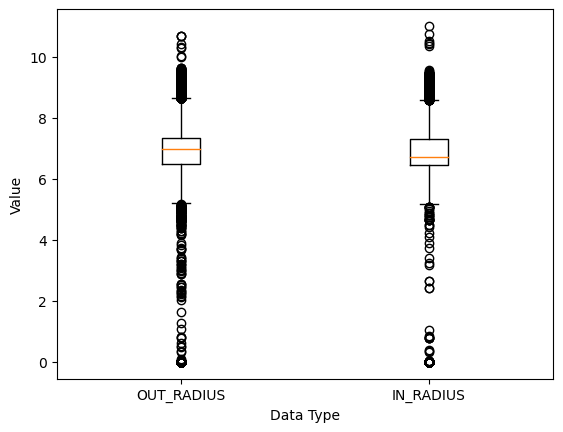

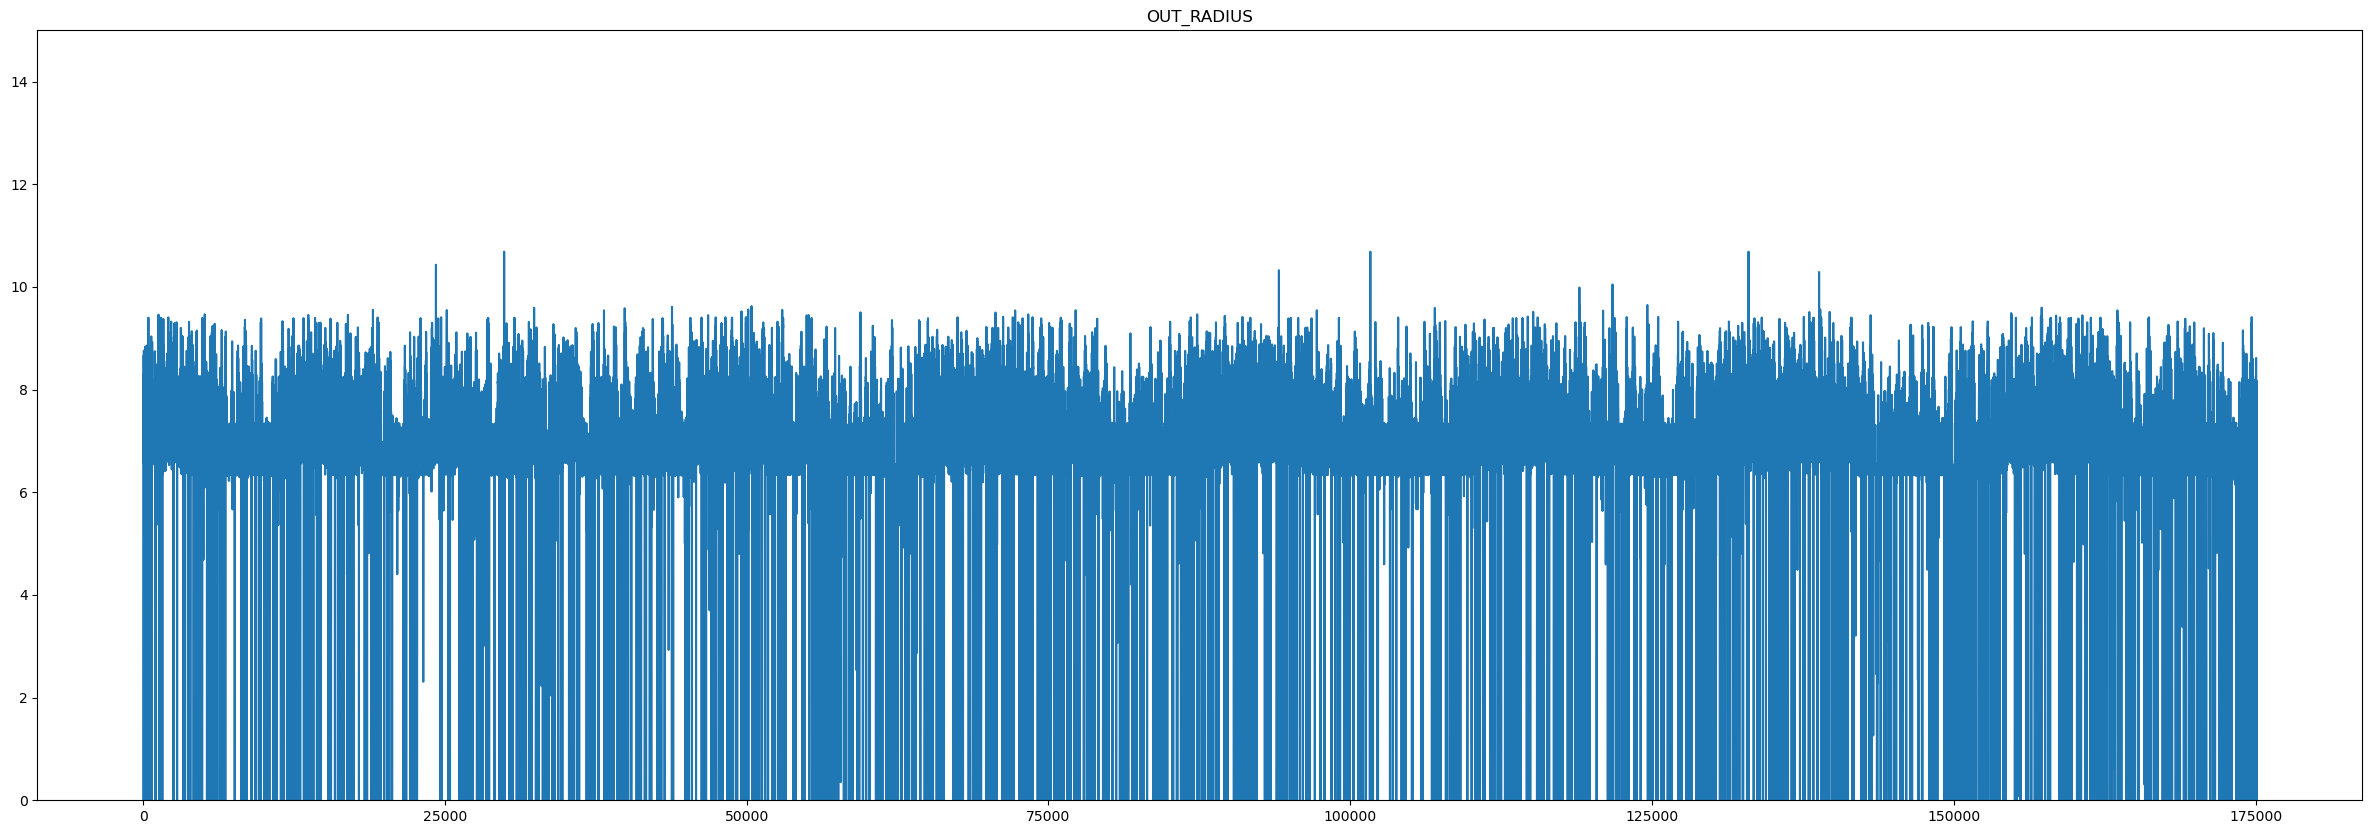

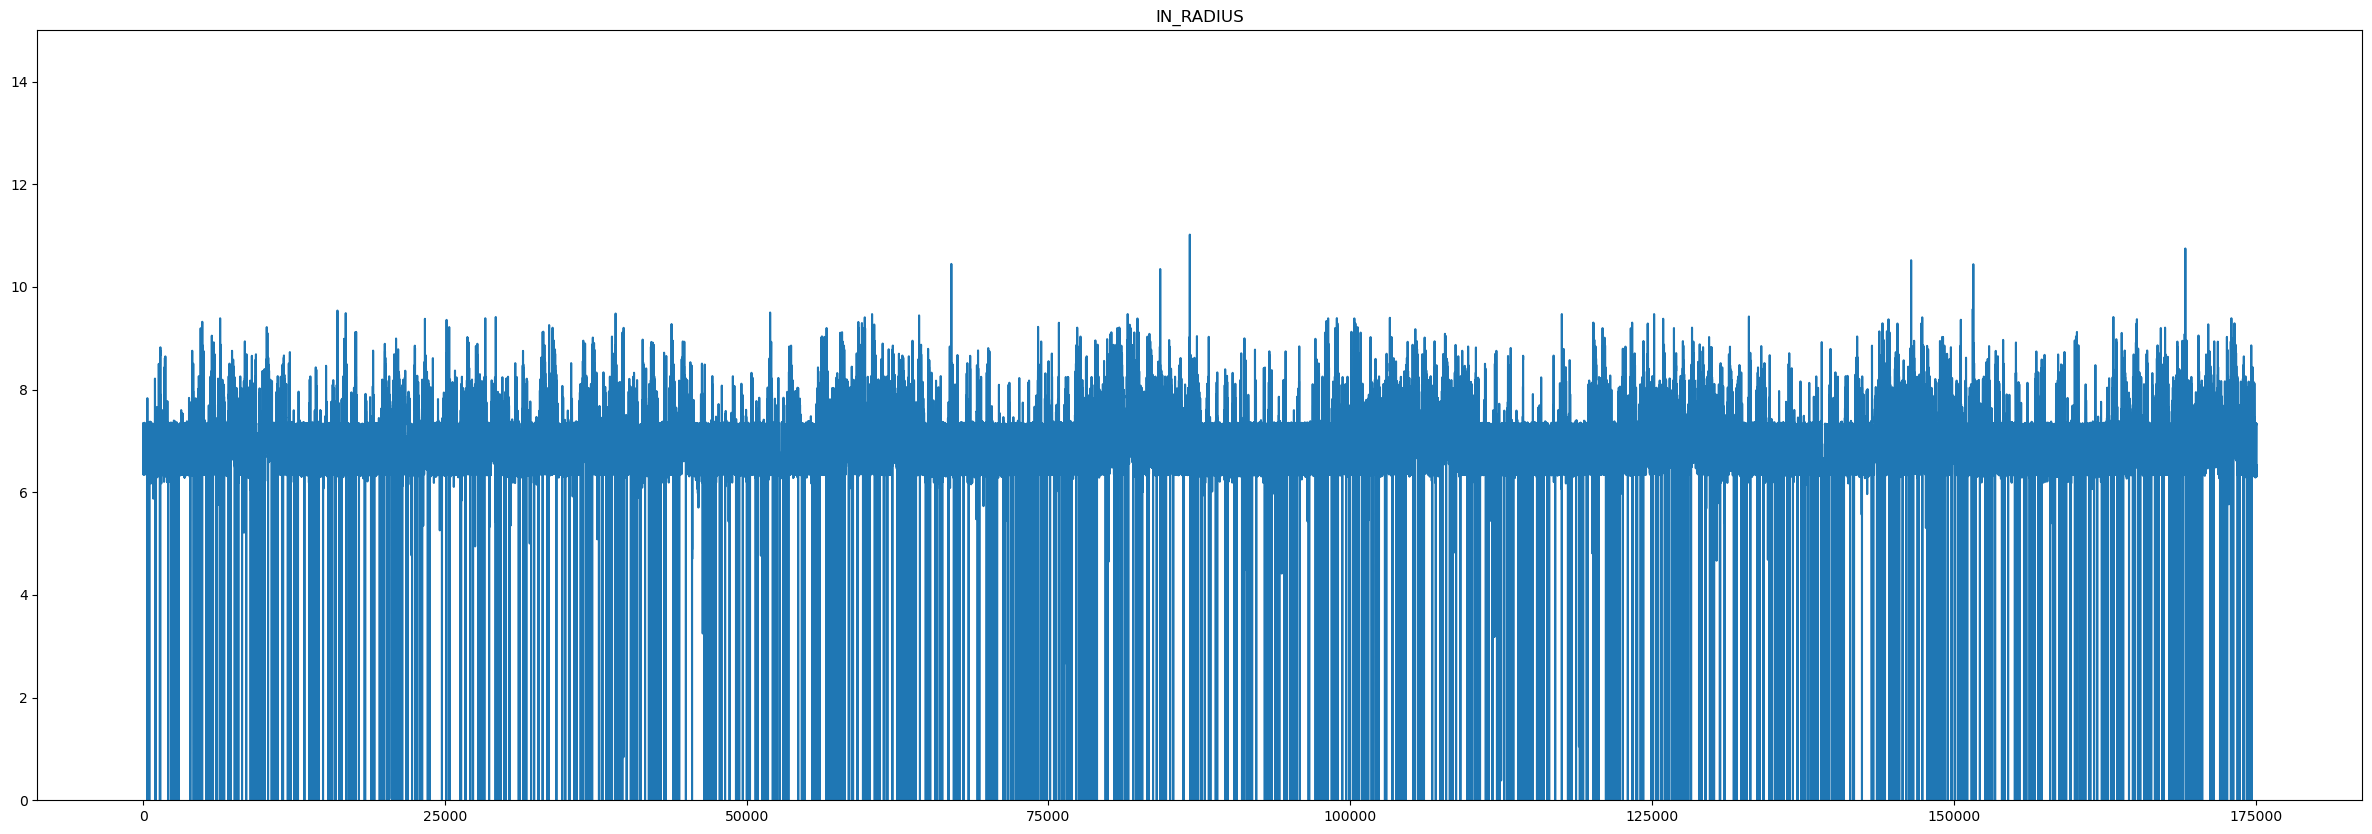

In [7]:
fig, ax = plt.subplots()

ax.boxplot([new_df['OUT_RADIUS'], new_df['IN_RADIUS']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
plt.xticks([1, 2], ['OUT_RADIUS','IN_RADIUS'])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['OUT_RADIUS'])
plt.title('OUT_RADIUS')
plt.ylim([0,15])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['IN_RADIUS'])
plt.title('IN_RADIUS')
plt.ylim([0,15])
plt.show()

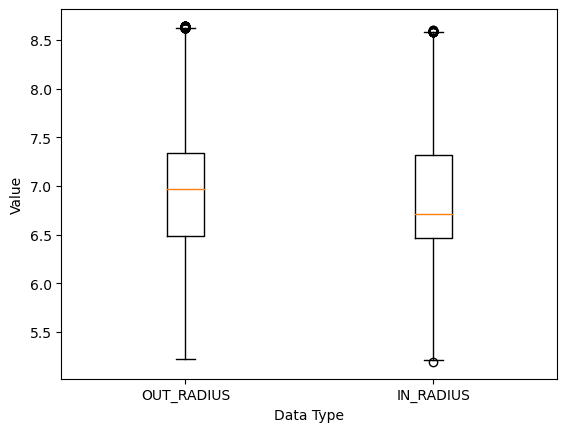

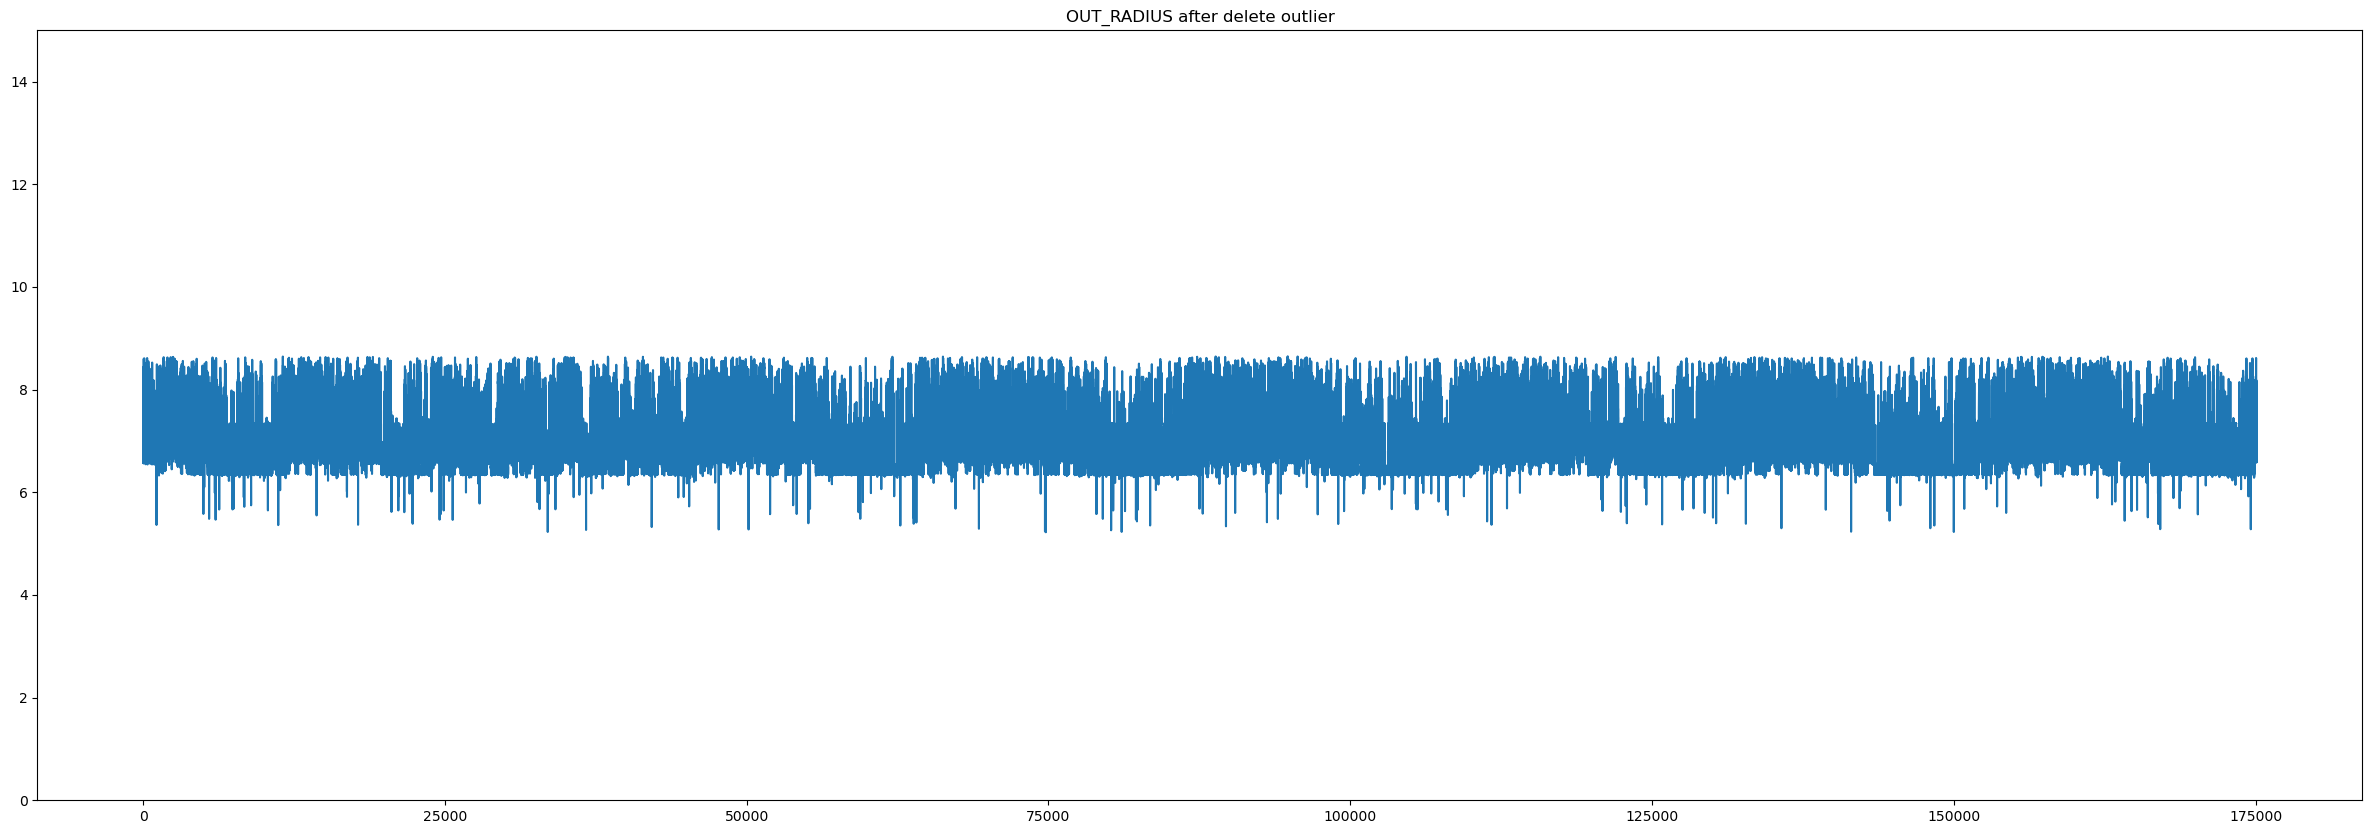

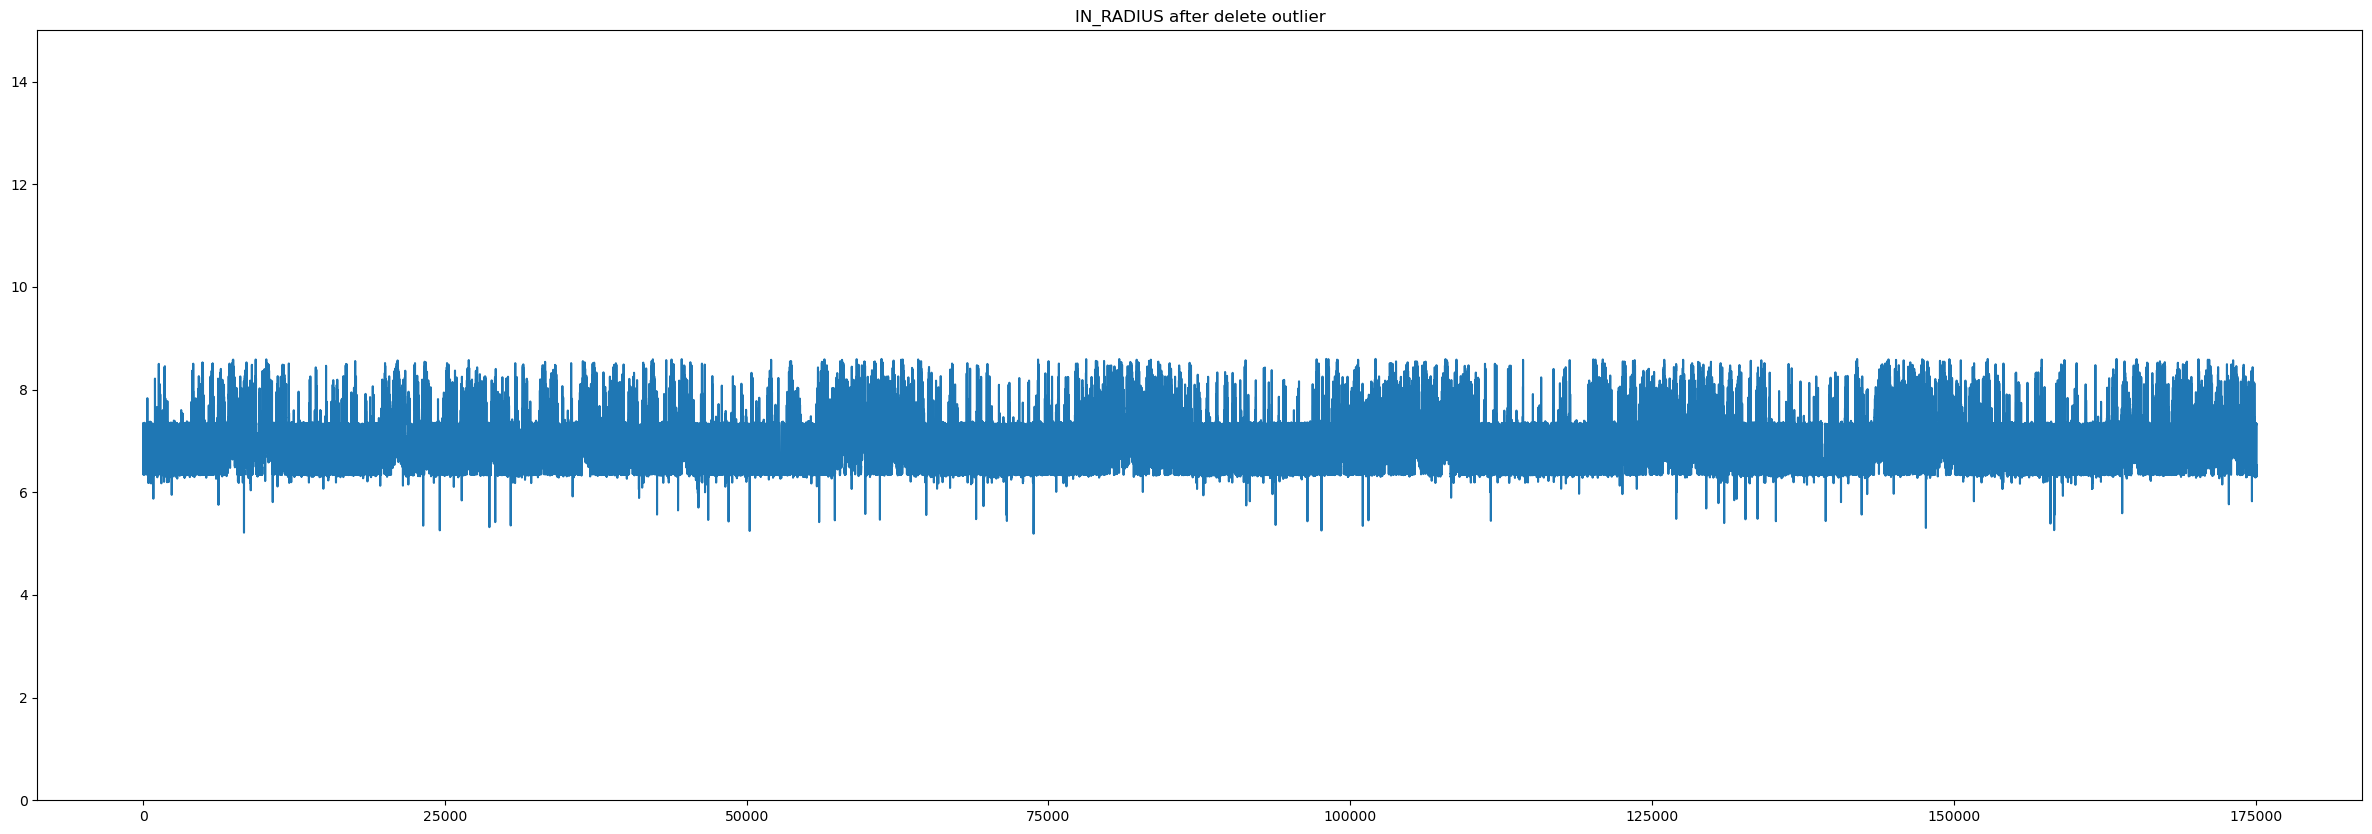

In [8]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

# 함수 사용해서 이상치 값 삭제
outlier_idx_in_rad = get_outlier(df=new_df, column='IN_RADIUS', weight=1.5)
new_df = new_df.drop(outlier_idx_in_rad,axis=0)
outlier_idx_out_rad = get_outlier(df=new_df, column='OUT_RADIUS', weight=1.5)
new_df = new_df.drop(outlier_idx_out_rad,axis=0)

outlier_idx_in_rad = get_outlier(df=anomaly_df, column='IN_RADIUS', weight=1.5)
anomaly_df = anomaly_df.drop(outlier_idx_in_rad,axis=0)
outlier_idx_out_rad = get_outlier(df=anomaly_df, column='OUT_RADIUS', weight=1.5)
anomaly_df = anomaly_df.drop(outlier_idx_out_rad,axis=0)

fig, ax = plt.subplots()

ax.boxplot([new_df['OUT_RADIUS'], new_df['IN_RADIUS']])
ax.set_xlabel('Data Type')
ax.set_ylabel('Value')
plt.xticks([1, 2], ['OUT_RADIUS','IN_RADIUS'])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['OUT_RADIUS'])
plt.title('OUT_RADIUS after delete outlier')
plt.ylim([0,15])
plt.show()

plt.figure(figsize=(30,10))
plt.plot(new_df['IN_RADIUS'])
plt.title('IN_RADIUS after delete outlier')
plt.ylim([0,15])
plt.show()

In [9]:
new_df['target'] = 0
anomaly_df['target'] = 1

In [10]:
new_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
1,EQUIP2,1,-6.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50,0
3,EQUIP2,6,-7.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62,0
4,EQUIP3,1,-0.75,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87,0
5,EQUIP4,8,-4.00,CORE1 A 02. 0570,CORE1 A 01. P1+2,CORE1 A 05. M0650,CORE1 A 08. C-06,6.4829,7.1508,-4.00,-4.00,-3.87,-3.87,-4.12,-4.12,0
6,EQUIP5,6,-8.50,CORE1 A 02. 0570,CORE1 A 01. P3+2,CORE1 A 05. M1550,CORE1 A 08. C-15,6.4800,8.2939,-8.50,-8.25,-8.25,-8.37,-8.37,-8.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175095,EQUIP37,1,-4.00,CORE5 F 01. 0570,CORE5 F 01. OK+1,CORE5 F 02. M0675,CORE5 F 02. D-06,6.3326,6.9997,-4.00,-4.12,-4.12,-4.00,-4.00,-4.00,0
175096,EQUIP37,8,-4.75,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0775,CORE5 F 02. D-07,6.3279,7.0979,-4.75,-4.75,-4.75,-4.75,-4.75,-4.75,0
175097,EQUIP13,4,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0850,CORE5 F 02. C-08,6.3304,7.1881,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25,0
175098,EQUIP13,5,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+2,CORE5 F 02. M0875,CORE5 F 02. D-08,6.4933,6.8071,-5.25,-5.12,-5.12,-5.25,-5.25,-5.25,0


In [11]:
anomaly_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
121,EQUIP15,4,-3.25,CORE1 A 02. 0570,CORE1 A 01. P2+2,CORE1 A 05. M0625,CORE1 A 08. B-06,6.4741,7.1521,-3.50,-3.37,-3.37,-3.50,-3.50,-3.50,1
2297,EQUIP27,2,-8.00,CORE2 C 03. 0660,CORE2 C 03. P1-2,CORE2 C 04. M0475,CORE2 C 04. D-04,7.3455,7.9546,-3.50,-3.50,-3.50,-3.37,-3.37,-3.37,1
2893,EQUIP13,7,-5.00,CORE1 B 02. 0550,CORE1 B 01. P2+0,CORE1 B 02. M0850,CORE1 B 02. C-08,7.2074,6.3643,-5.25,-5.25,-5.25,-5.25,-5.00,-5.00,1
3175,EQUIP26,6,-6.00,CORE2 C 03. 0660,CORE2 C 03. OK+2,CORE2 C 04. M0925,CORE2 C 04. B-09,8.5852,7.3512,-6.50,-6.50,-6.65,-6.75,-6.75,-6.75,1
4051,EQUIP2,3,-3.75,CORE3 C 01. 0660,CORE3 C 01. P1-1,CORE3 C 03. M0525,CORE3 C 03. B-05,8.0007,7.3452,-3.50,-3.50,-3.62,-3.62,-3.62,-3.62,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174123,EQUIP33,3,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0825,CORE5 F 02. B-08,7.1685,6.2684,-5.50,-5.50,-5.62,-5.62,-5.62,-5.62,1
174238,EQUIP16,5,-2.50,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0325,CORE2 C 04. B-03,7.3764,7.7534,-2.25,-2.25,-2.25,-2.25,-2.25,-2.37,1
174257,EQUIP12,6,-1.75,CORE5 E 01. 0590,CORE5 E 01. M2+0,CORE5 E 02. M0300,CORE5 E 02. A-03,6.5082,6.8625,-2.25,-2.25,-2.25,-2.12,-2.12,-2.12,1
174862,EQUIP7,8,-4.00,CORE5 E 01. 0590,CORE5 E 01. M1+0,CORE5 E 02. M0650,CORE5 E 02. C-06,6.5094,7.2148,-4.25,-4.25,-4.25,-4.25,-4.37,-4.37,1


In [13]:
data_df = pd.concat([new_df,anomaly_df])
data_df

,EQUIP_ID,MOLD_POS,REAL_POWER,MOLD_IN_TOP,MOLD_IN_BOT,MOLD_OUT_TOP,MOLD_OUT_BOT,IN_RADIUS,OUT_RADIUS,POWER,POWER1,POWER2,POWER3,POWER4,POWER5,target
1,EQUIP2,1,-6.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1050,CORE1 B 02. C-10,6.3564,7.4551,-6.50,-6.25,-6.25,-6.37,-6.50,-6.50,0
3,EQUIP2,6,-7.50,CORE1 B 02. 0550,CORE1 B 01. P2+1,CORE1 B 02. M1250,CORE1 B 02. C-12,6.3600,7.6877,-7.50,-7.50,-7.50,-7.62,-7.62,-7.62,0
4,EQUIP3,1,-0.75,CORE3 C 01. 0660,CORE3 C 01. OK+2,CORE3 C 03. M0125,CORE3 C 03. B-01,7.3411,7.5236,-0.75,-0.87,-0.87,-0.87,-0.87,-0.87,0
5,EQUIP4,8,-4.00,CORE1 A 02. 0570,CORE1 A 01. P1+2,CORE1 A 05. M0650,CORE1 A 08. C-06,6.4829,7.1508,-4.00,-4.00,-3.87,-3.87,-4.12,-4.12,0
6,EQUIP5,6,-8.50,CORE1 A 02. 0570,CORE1 A 01. P3+2,CORE1 A 05. M1550,CORE1 A 08. C-15,6.4800,8.2939,-8.50,-8.25,-8.25,-8.37,-8.37,-8.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174123,EQUIP33,3,-5.25,CORE5 F 01. 0570,CORE5 F 01. OK+0,CORE5 F 02. M0825,CORE5 F 02. B-08,7.1685,6.2684,-5.50,-5.50,-5.62,-5.62,-5.62,-5.62,1
174238,EQUIP16,5,-2.50,CORE2 C 03. 0660,CORE2 C 03. P1+0,CORE2 C 04. M0325,CORE2 C 04. B-03,7.3764,7.7534,-2.25,-2.25,-2.25,-2.25,-2.25,-2.37,1
174257,EQUIP12,6,-1.75,CORE5 E 01. 0590,CORE5 E 01. M2+0,CORE5 E 02. M0300,CORE5 E 02. A-03,6.5082,6.8625,-2.25,-2.25,-2.25,-2.12,-2.12,-2.12,1
174862,EQUIP7,8,-4.00,CORE5 E 01. 0590,CORE5 E 01. M1+0,CORE5 E 02. M0650,CORE5 E 02. C-06,6.5094,7.2148,-4.25,-4.25,-4.25,-4.25,-4.37,-4.37,1


In [14]:
data_df['POWER_MEAN'] = (data_df['POWER1'] + data_df['POWER2'] + data_df['POWER3'] + data_df['POWER4'] + data_df['POWER5']) / 5
df_final = data_df.drop(['EQUIP_ID','POWER_MEAN','POWER','POWER1','POWER2','POWER3','POWER4','POWER5','MOLD_IN_TOP','MOLD_IN_BOT','MOLD_OUT_TOP','MOLD_OUT_BOT'],axis=1)
df_final

,MOLD_POS,REAL_POWER,IN_RADIUS,OUT_RADIUS,target
1,1,-6.50,6.3564,7.4551,0
3,6,-7.50,6.3600,7.6877,0
4,1,-0.75,7.3411,7.5236,0
5,8,-4.00,6.4829,7.1508,0
6,6,-8.50,6.4800,8.2939,0
...,...,...,...,...,...
174123,3,-5.25,7.1685,6.2684,1
174238,5,-2.50,7.3764,7.7534,1
174257,6,-1.75,6.5082,6.8625,1
174862,8,-4.00,6.5094,7.2148,1


In [15]:
#df_encoded = pd.get_dummies(df_final,columns=['MOLD_POS','EQUIP_ID','MOLD_IN_TOP','MOLD_IN_BOT',"MOLD_OUT_TOP",'MOLD_OUT_BOT'])
df_encoded = pd.get_dummies(df_final,columns=['MOLD_POS','EQUIP_ID'])
df_encoded

,REAL_POWER,IN_RADIUS,OUT_RADIUS,target,MOLD_POS_1,MOLD_POS_2,MOLD_POS_3,MOLD_POS_4,MOLD_POS_5,MOLD_POS_6,MOLD_POS_7,MOLD_POS_8,MOLD_POS_9,MOLD_POS_10,MOLD_POS_11,MOLD_POS_12,MOLD_POS_13,MOLD_POS_14,MOLD_POS_15,MOLD_POS_16
1,-6.50,6.3564,7.4551,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,-7.50,6.3600,7.6877,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,-0.75,7.3411,7.5236,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,-4.00,6.4829,7.1508,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
6,-8.50,6.4800,8.2939,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174123,-5.25,7.1685,6.2684,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
174238,-2.50,7.3764,7.7534,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
174257,-1.75,6.5082,6.8625,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
174862,-4.00,6.5094,7.2148,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [16]:
df_y = df_encoded['target']
df_x = df_encoded.drop('target',axis=1)

#df_y = df_encoded['POWER_MEAN']
#df_x = df_encoded.drop('POWER_MEAN',axis=1)
#df_y = df_encoded['REAL_POWER']
#df_x = df_encoded.drop('REAL_POWER',axis=1)

In [17]:
train_x, val_x, train_y, val_y = train_test_split(df_x, df_y, test_size = 0.2, stratify = df_y, random_state=SEED)
train_x.reset_index(drop=True, inplace=True)
val_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
val_y.reset_index(drop=True, inplace=True)

In [18]:
val_y.value_counts()

target
0    28661
1      109
Name: count, dtype: int64

In [19]:
train_x.isnull().sum()

REAL_POWER     0
IN_RADIUS      0
OUT_RADIUS     0
MOLD_POS_1     0
MOLD_POS_2     0
MOLD_POS_3     0
MOLD_POS_4     0
MOLD_POS_5     0
MOLD_POS_6     0
MOLD_POS_7     0
MOLD_POS_8     0
MOLD_POS_9     0
MOLD_POS_10    0
MOLD_POS_11    0
MOLD_POS_12    0
MOLD_POS_13    0
MOLD_POS_14    0
MOLD_POS_15    0
MOLD_POS_16    0
dtype: int64

In [20]:
train_y.isnull().sum()

0

In [21]:
train_y

0         0
1         0
2         0
3         0
4         0
         ..
115074    0
115075    0
115076    0
115077    0
115078    0
Name: target, Length: 115079, dtype: int64

In [22]:
scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x)
val_x_scaled = scaler.fit_transform(val_x)

In [23]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier

In [24]:
seed_everything(SEED)
sampler = TPESampler(seed=SEED)
def objective(trial):
    
    param = {
        "verbosity": 1,
        'lambda': trial.suggest_float('lambda', 1e-3, 1e-1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1e-1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
        'max_depth': trial.suggest_int('max_depth', 4,20),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 50),
        'random_state' : SEED,
        'eval_metric' : 'logloss',
        'gpu_id': -1,  # CPU 사용시
    }

    model = XGBClassifier(**param)  
    
    model.fit(train_x,train_y)
    #model.fit(train_hidden,train_y_np)
    pred= model.predict(val_x)
    f1 = f1_score(val_y, pred)
    print(confusion_matrix(val_y,pred))
    return f1
          
study_xgb = optuna.create_study(
    direction='maximize',
    study_name = 'Xgboost Optuna', 
    sampler=sampler
)
study_xgb.optimize(objective, n_trials=200)

[I 2023-05-15 19:41:03,251] A new study created in memory with name: Xgboost Optuna
[I 2023-05-15 19:41:33,948] Trial 0 finished with value: 0.0 and parameters: {'lambda': 0.03807947176588889, 'alpha': 0.0951207163345817, 'colsample_bytree': 0.839196365086843, 'subsample': 0.759195090518222, 'learning_rate': 0.01568626218019941, 'n_estimators': 1202, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 0 with value: 0.0.


[[28661     0]
 [  109     0]]


[W 2023-05-15 19:42:02,588] Trial 1 failed with parameters: {'lambda': 0.06051038616257767, 'alpha': 0.07109918520180851, 'colsample_bytree': 0.41235069657748147, 'subsample': 0.9819459112971965, 'learning_rate': 0.08326101981596214, 'n_estimators': 1455, 'max_depth': 7, 'min_child_weight': 10} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_73807/2134702699.py", line 22, in objective
    model.fit(train_x,train_y)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster

KeyboardInterrupt: 